In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [10]:
%matplotlib inline

In [11]:
sns.set(style="darkgrid")

## Read the data

In [12]:
hands = pd.read_csv("hands2.csv")

In [13]:
games = pd.read_csv("games2.csv")

### Test plots

## Basic hands analysis

### State statistics

A histogram with x labels indicate which state is which.

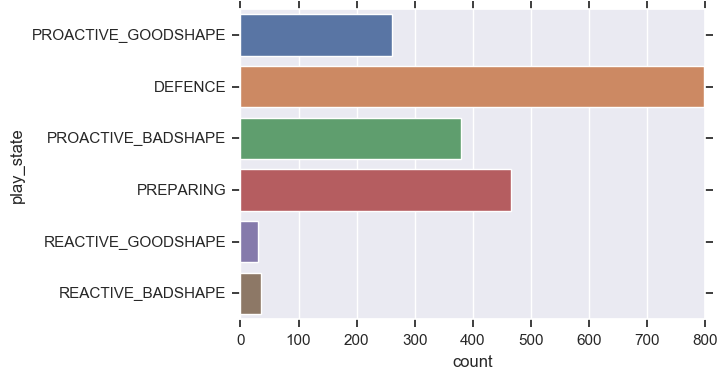

In [6]:
sns.countplot(y=hands["play_state"])

### State boxplot
I need to clearly see the average EV of each state.

Note that the "REACTIVE" data is too less. Not enough to adjust the algorithm.

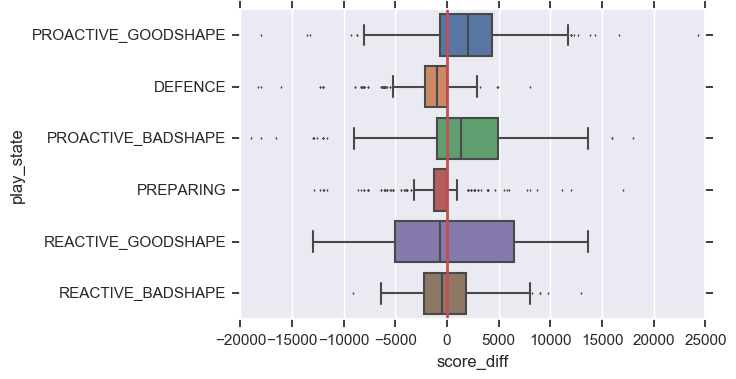

In [7]:
sns.boxplot(x="score_diff", y="play_state", data=hands, fliersize=1)
plt.axvline(color='r', linewidth=2)

### State index statistics

(1, 20)

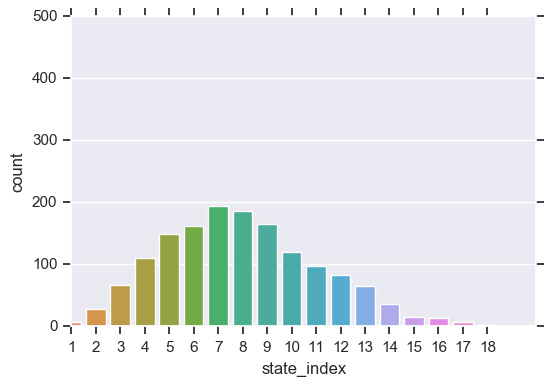

In [8]:
sns.countplot(x="state_index", data=hands).set_xlim(1, 20)

### Start defence index

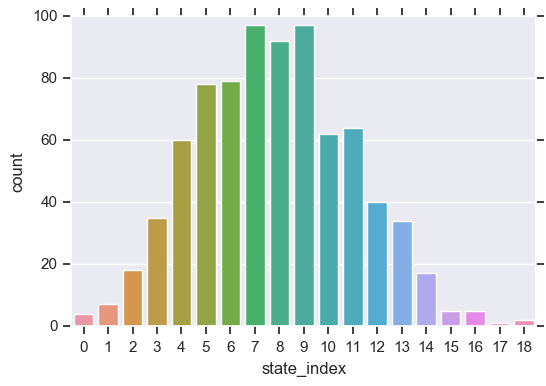

In [9]:
sns.countplot(x="state_index", data=hands[hands["play_state"]=="DEFENCE"])

### Score difference according to state index
After plotting, I find that data is not enough.

I want the "distplot" liked graph. Give me a barplot with a line telling me the dist of EV.

(-10000, 10000)

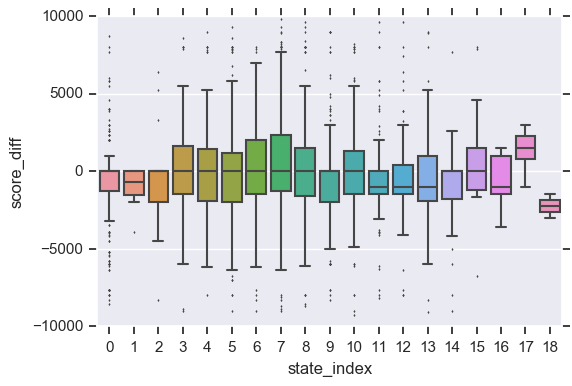

In [10]:
ax = sns.boxplot(x="state_index", y="score_diff", data=hands, fliersize=1)
ax.set_ylim(-10000, 10000)
#plt.axhline(color='r', linewidth=0.5)

### Score difference aacording to state index and state

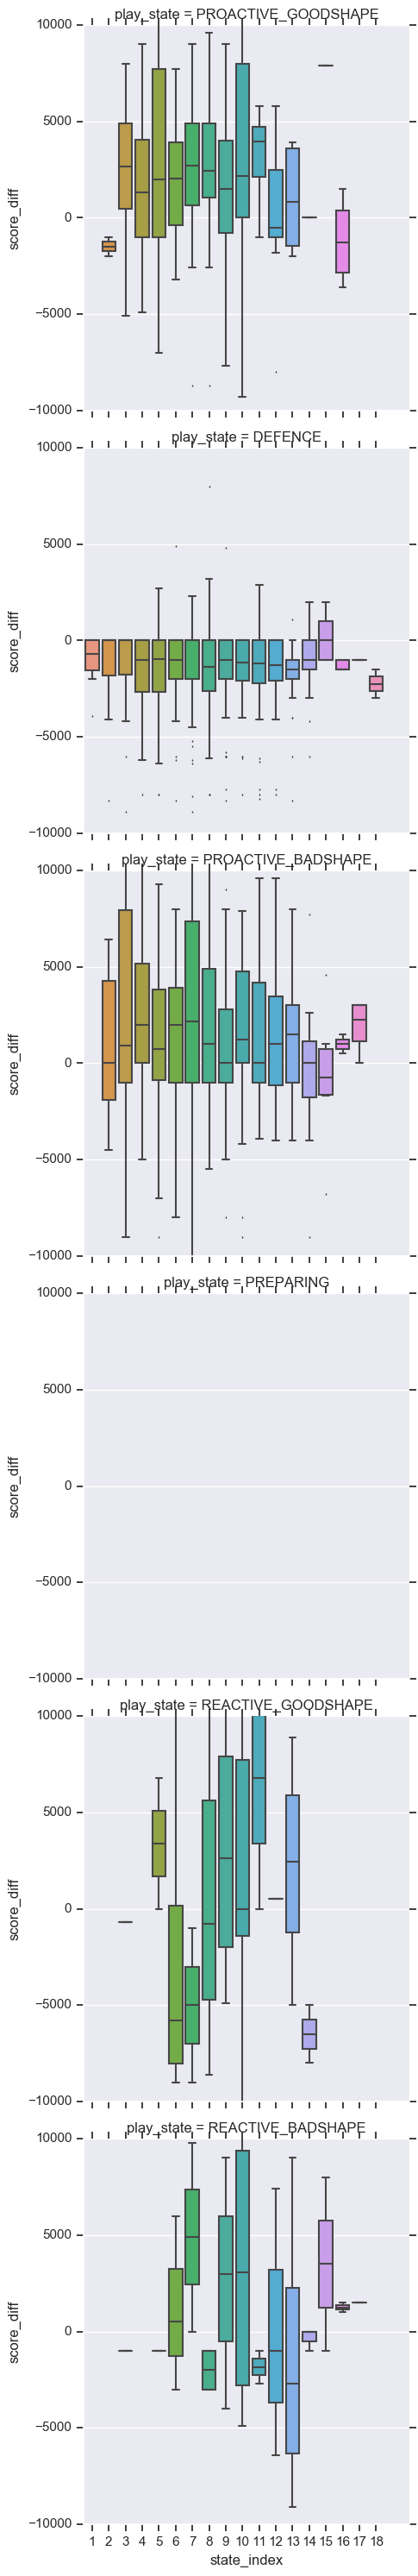

In [11]:
g = sns.catplot(x="state_index", y="score_diff", data=hands, row="play_state", kind="box", fliersize=1)
g.set(ylim=(-10000, 10000), xlim=(0.5,20))

### Score difference when at the 4th position
Data is not enough, need to collect more.

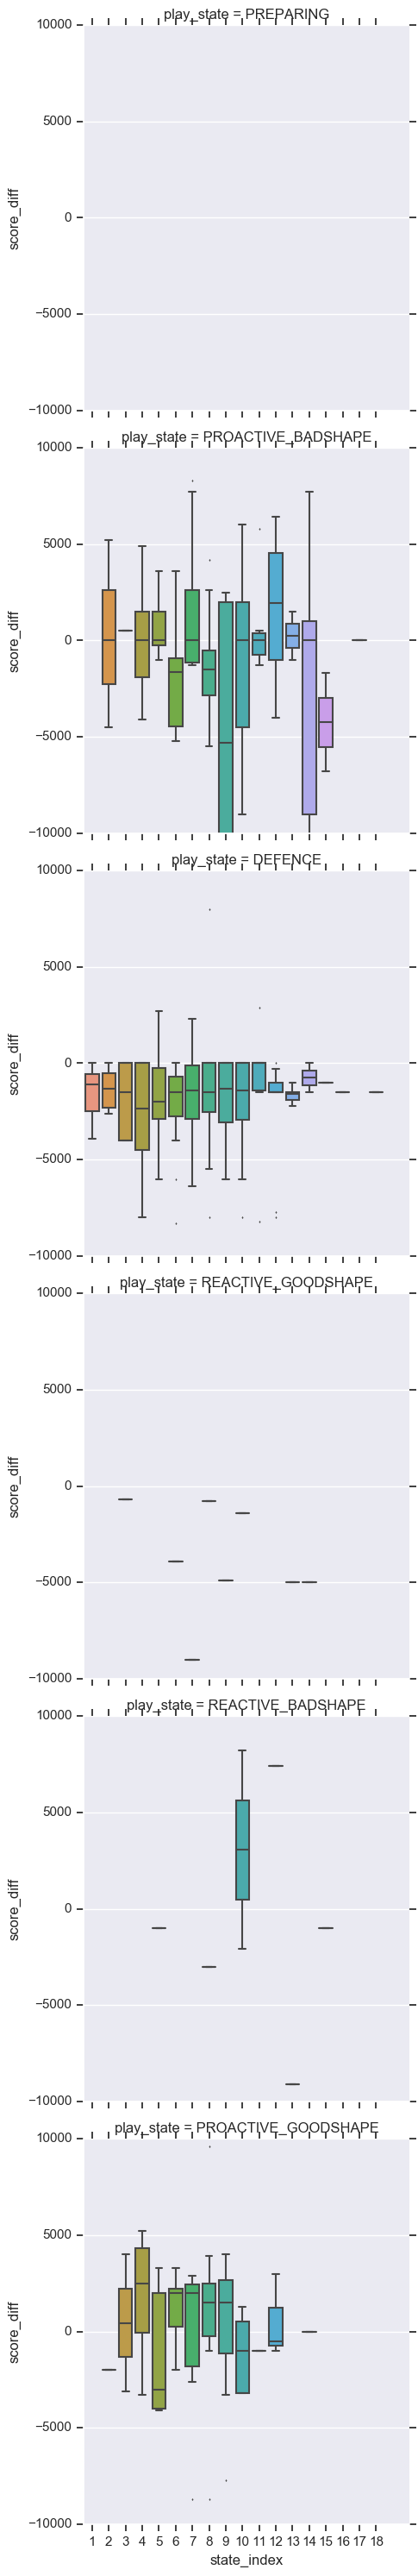

In [12]:
g = sns.catplot(x="state_index", y="score_diff", data=hands[hands["final_position"]==4], row="play_state", kind="box", fliersize=1)
g.set(ylim=(-10000, 10000), xlim=(0.5,20))

### Score and meld times

(-10000, 10000)

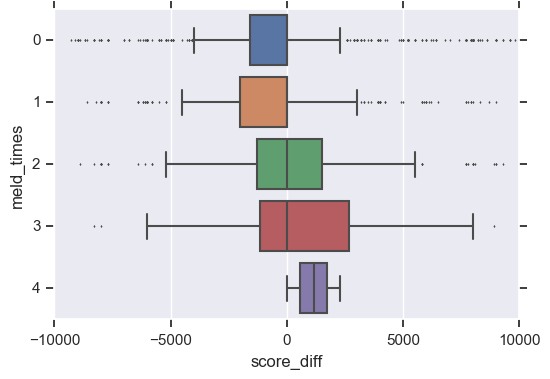

In [13]:
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands, fliersize=1)
ax.set_xlim(-10000, 10000)

(-10000, 10000)

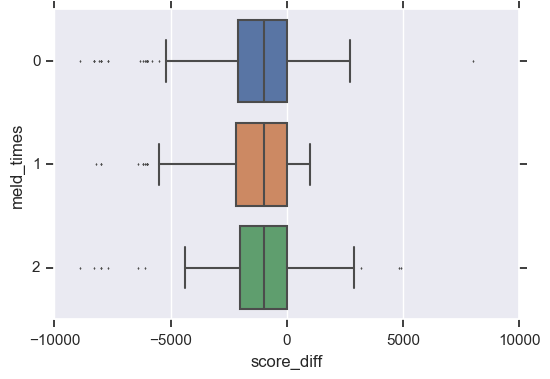

In [14]:
## defence when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] == "DEFENCE") & (hands["meld_times"] < 3)], fliersize=1)
ax.set_xlim(-10000, 10000)

(-10000, 10000)

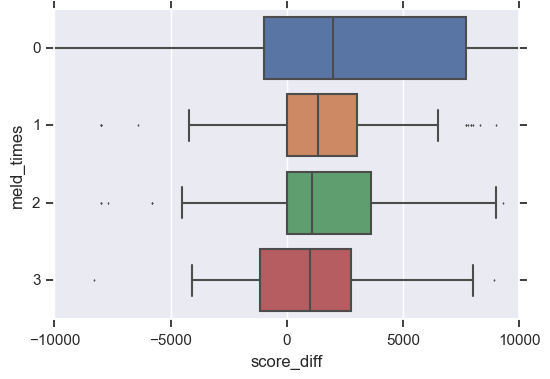

In [15]:
## offense when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] != "DEFENCE") & (hands["play_state"] != "PREPARING") & (hands["meld_times"] < 4)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Score and reach

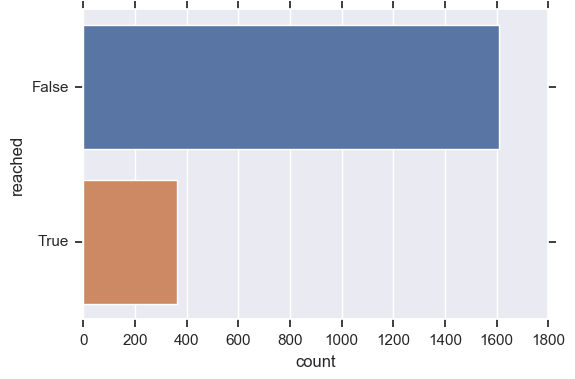

In [16]:
sns.countplot(y="reached", data=hands)

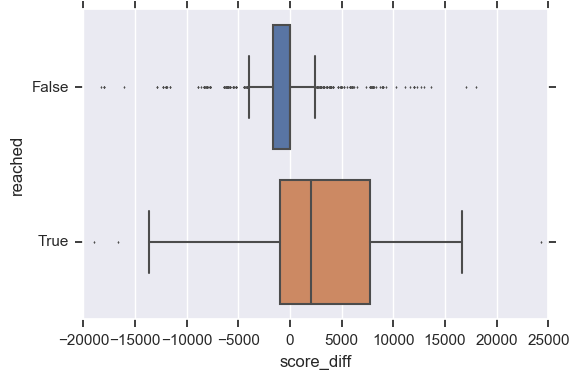

In [17]:
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands, fliersize=1)

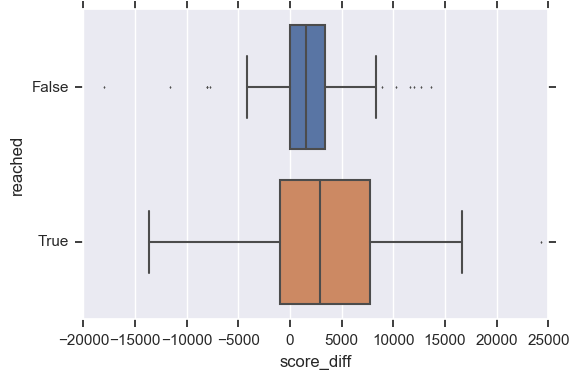

In [18]:
## GoodShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_GOODSHAPE") | (hands["play_state"]=="REACTIVE_GOODSHAPE")], fliersize=1)

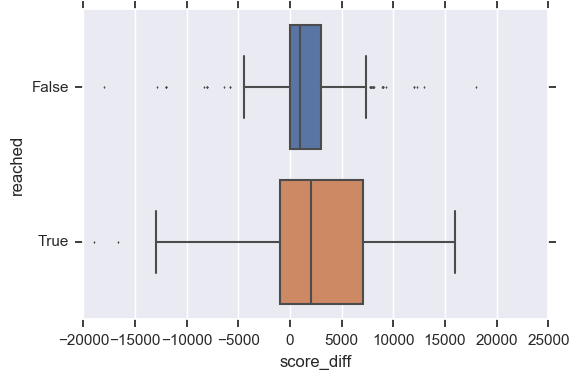

In [19]:
## BadShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_BADSHAPE") | (hands["play_state"]=="REACTIVE_BADSHAPE")], fliersize=1)

In hands2, the EV for badshape offense shows that reached is lower than unreached. After reaching condition for bad shape hands is tuned, this will be better.

### About game results

In [20]:
final_position = games["final_position"]

In [21]:
## Position ratio calculated
position_ratio = [(final_position==i).mean() for i in range(1,5)]
position_ratio

[0.17582417582417584,
 0.23626373626373626,
 0.35714285714285715,
 0.23076923076923078]

In [22]:
## Final Rate
current_rate = 1500

## Final Dan
i = 1
current_pt = 200
for play_count in range(3000):
    
    # change this to change the gamemode
    upper_dan = True
    phoenix = True
    
    delta_pt = [60, 15, 0]
    avg_rate = 1700
    if i >= 4 and current_rate >= 1800 and upper_dan:
        delta_pt = [75, 30, 0]
        avg_rate = 1900
    if i >= 7 and current_rate >= 2000 and phoenix:
        delta_pt = [90, 45, 0]
        avg_rate = 2100
    
    delta_pt.append(- (30 + i * 15))
    
    current_pt += np.dot(np.float32(delta_pt), position_ratio)
    delta_rate = np.dot(np.array(position_ratio), np.array([30, 10, -10, -30]))
    delta_rate += (avg_rate - current_rate) / 40
    current_rate += 0.2 * delta_rate
    
    if current_pt > i * 400:
        i += 1
        current_pt = i * 200
    elif current_pt < 0:
        i -= 1
        current_pt = i * 200
        
    if i > 10:
        print("Achieve 天凤 with play count {}".format(play_count))
        break
        
print("Final dan: {} with pt {}".format(i, current_pt))
print("Final rate: {}".format(current_rate))

Final dan: 2 with pt 682.1153846154045
Final rate: 1585.7142604623068


### South position and final position

In [23]:
_, row = next(games.iterrows())

In [24]:
pos_diff = np.zeros([4, 4])
for _, row in games.iterrows():
    pos_diff[row["final_position"]-1,row["south_position"]-1]+=1

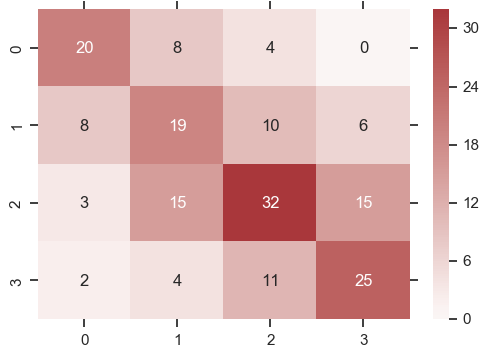

In [25]:
sns.heatmap(pos_diff, center=0, cmap="vlag", annot=True)

In [26]:
# score data preprocessing
score_preprocess = lambda x: int("".join(x.split(",")))
games["south_score"] = games["south_score"].apply(score_preprocess)
games["final_score"] = games["final_score"].apply(score_preprocess)

In [27]:
# Mean score
print("South main:", games["south_score"].mean(), games["south_position"].mean())
print("Final main:", games["final_score"].mean(), games["final_position"].mean())

South main: 23848.351648351647 2.6373626373626373
Final main: 23163.186813186814 2.642857142857143


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


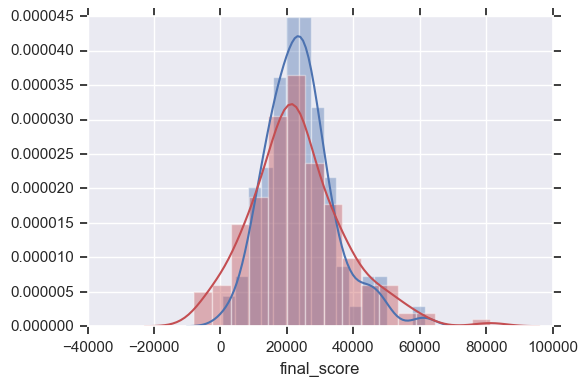

In [28]:
ax = sns.distplot(games["south_score"])
sns.distplot(games["final_score"], color="r", ax=ax)

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


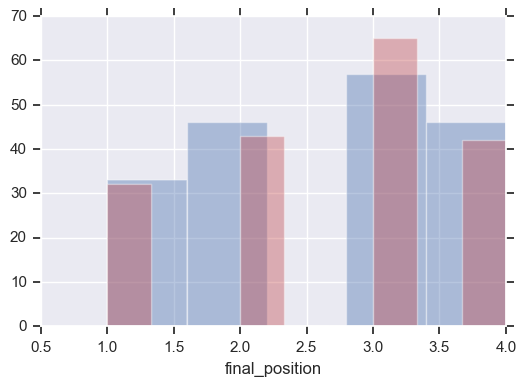

In [29]:
ax = sns.distplot(games["south_position"], kde=False, color="b")
sns.distplot(games["final_position"], kde=False, color="r", ax=ax)

## According to final position

### Final position with states

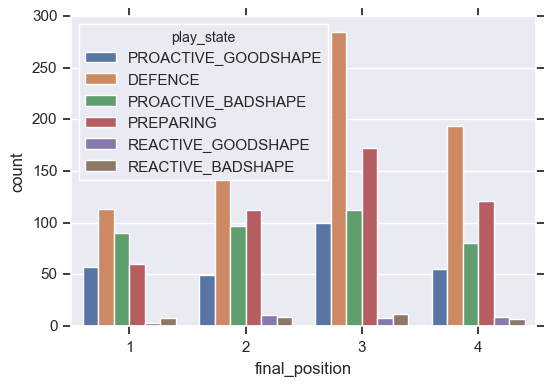

In [30]:
sns.countplot(x="final_position", hue="play_state", data=hands)

### Final position with melds

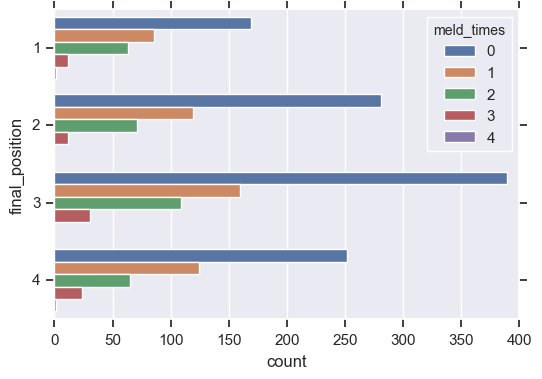

In [31]:
sns.countplot(y="final_position", hue="meld_times", data=hands)

### Final position with reach

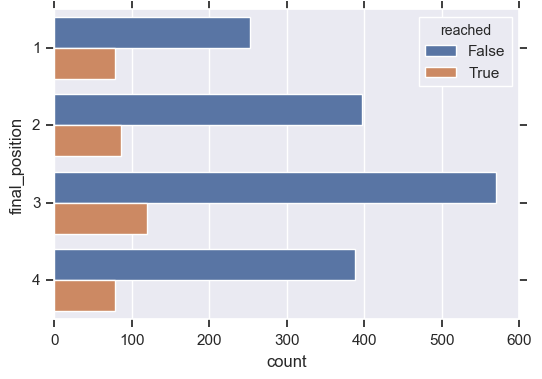

In [32]:
sns.countplot(y="final_position", hue="reached", data=hands)

## Final position with reach times and meld times
Time to use groupby!

## Error Analysis

In [14]:
games.head()

,Unnamed: 0,game_index,south_score,final_score,south_position,final_position
0,0,29847,"44,400","44,400",1,1
1,1,2019020917gm-0089-0000-f0a8e478&tw=1,"13,000","13,000",3,3
2,2,2019020918gm-0089-0000-a25a2e0c&tw=0,"19,600","30,300",2,2
3,3,2019020918gm-0089-0000-969c0a8f&tw=0,"35,300","44,600",1,1
4,4,2019020919gm-0089-0000-ecbb68bc&tw=0,"30,300","25,500",2,2


In [15]:
game_indexes_4 = games[games["final_position"]==4]["game_index"]

In [21]:
for game_index in game_indexes_4:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019020920gm-0089-0000-31c33f9c&tw=0

http://tenhou.net/3/?log=2019020921gm-0089-0000-3693c399&tw=2

http://tenhou.net/3/?log=2019020922gm-0089-0000-42e1e960&tw=1

http://tenhou.net/3/?log=2019021000gm-0089-0000-ac43cd03&tw=3

http://tenhou.net/3/?log=2019021005gm-0089-0000-6bed4000&tw=2

http://tenhou.net/3/?log=2019021005gm-0089-0000-8176317a&tw=2

http://tenhou.net/3/?log=2019021005gm-0089-0000-ae6ebb63&tw=3

http://tenhou.net/3/?log=2019021007gm-0089-0000-02c62f8a&tw=0

http://tenhou.net/3/?log=2019021008gm-0089-0000-17d6411b&tw=3

http://tenhou.net/3/?log=2019021010gm-0089-0000-0948e220&tw=2

http://tenhou.net/3/?log=2019021011gm-0089-0000-ddce3041&tw=3

http://tenhou.net/3/?log=2019021012gm-0089-0000-14de8bbc&tw=1

http://tenhou.net/3/?log=2019021014gm-0089-0000-21f1f76a&tw=1

http://tenhou.net/3/?log=2019021014gm-0089-0000-3158ae8d&tw=2

http://tenhou.net/3/?log=2019021015gm-0089-0000-2945b191&tw=0

http://tenhou.net/3/?log=2019021017gm-0089-0000-f94ff99